# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup as soup # HTML parser
import requests # Page requests
import re # Regular expressions
import time # Time delays
import random # Random numbers


header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/sss?query=bikes#search=2~gallery~0'
raw = requests.get(url,headers=header) # Get page

#web scraping


We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/charlottesville-va/mca?lat=37.9245&lon=-78.3957&search_distance=108#search=2~gallery~0'  # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [75]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want
print(listings[0].prettify())

<li class="cl-static-search-result" title="1981 Yamaha XS650">
 <a href="https://martinsburg.craigslist.org/mcy/d/martinsburg-1981-yamaha-xs650/7912413612.html">
  <div class="title">
   1981 Yamaha XS650
  </div>
  <div class="details">
   <div class="price">
    $3,400
   </div>
   <div class="location">
    Martinsburg
   </div>
  </div>
 </a>
</li>



Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [76]:
import re
import numpy as np

# Motorcycle brands (like professor's car brands list)
brands = ['harley', 'davidson', 'honda', 'yamaha', 'kawasaki', 'suzuki', 'ducati',
          'bmw', 'triumph', 'ktm', 'indian', 'victory', 'aprilia', 'husqvarna']

data = []  # We'll save our listings in this object

for k in range(len(listings)):
    # Find elements first
    title_elem = listings[k].find('div', class_='title')
    price_elem = listings[k].find('div', class_='price')
    link_elem = listings[k].find(href=True)

    # Skip if missing required fields
    if not title_elem or not price_elem or not link_elem:
        continue

    title = title_elem.get_text().lower()
    price = price_elem.get_text()
    link = link_elem['href']

    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands]  # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]

    # Get year from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title)  # Find year references
    if regex_search is None:  # If no hits, record year as missing value
        year = np.nan
    else:  # If hits, record year as first match
        year = regex_search.group(0)

    data.append({'title': title, 'price': price, 'year': year, 'brand': brand, 'link': link})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [77]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)

# Clean price (same as professor)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Clean bedrooms (convert to numeric, similar to year)
#df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')

# You could create a new variable like price per bedroom
#df['price_per_bedroom'] = df['price'] / df['bedrooms']

print(df.shape)
df.to_csv('./craigslist_cville_furniture.csv')  # Save data
df.head()

(95, 5)


,title,price,year,brand,link
0,1981 yamaha xs650,3400,1981,yamaha,https://martinsburg.craigslist.org/mcy/d/marti...
1,1978 yamaha xs650 survivor beauty,3900,1978,yamaha,https://martinsburg.craigslist.org/mcy/d/marti...
2,bmw s1000xr sport touring motorcycle,8500,NaN,bmw,https://roanoke.craigslist.org/mcy/d/roanoke-b...
3,2013 harley davidson electra glide classic,9500,2013,harley,https://frederick.craigslist.org/mcy/d/brunswi...
4,2009 harley ultra classic,6000,2009,harley,https://smd.craigslist.org/mcy/d/hughesville-2...


With the data in and wrangled, we can now do some analysis:

count       95.000000
mean      5914.936842
std       4711.690634
min          0.000000
25%       2450.000000
50%       5500.000000
75%       7650.000000
max      22500.000000
Name: price, dtype: float64


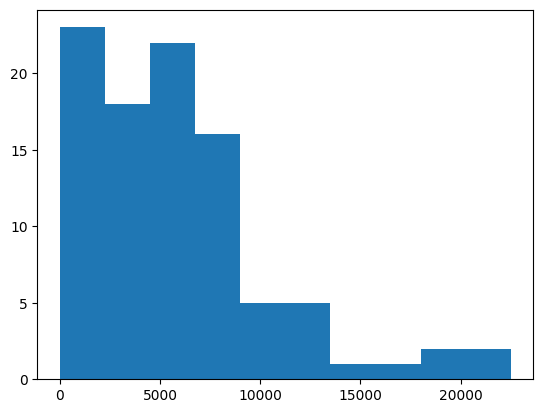

In [78]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()


In [79]:
# Price by brand:
df.loc[:,['price','year']].groupby('year').describe()
# Check how many listings have years
print(f"Total listings: {len(df)}")
print(f"Listings with years: {df['year'].notna().sum()}")
print(f"Listings with brands: {(df['brand'] != 'missing').sum()}")
print(f"\nYear value counts:")
print(df['year'].value_counts())

Total listings: 95
Listings with years: 72
Listings with brands: 69

Year value counts:
year
2021    5
2009    5
2017    4
2022    4
2003    4
2023    4
2024    3
1996    3
2015    3
2005    3
1979    3
2013    3
2019    3
2004    2
2011    2
2007    2
2012    2
1981    1
1978    1
2018    1
2006    1
2002    1
1972    1
1997    1
2008    1
2001    1
2020    1
1980    1
2014    1
1999    1
1973    1
2016    1
1977    1
2025    1
Name: count, dtype: int64


In [84]:
# Age by brand:
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                        \
         count          mean          std      min      25%      50%   
brand                                                                  
bmw        6.0   4420.166667  3196.524514     22.0   2350.0   4500.0   
ducati     2.0  17400.000000  3394.112550  15000.0  16200.0  17400.0   
harley    22.0   8828.818182  4831.336477   3500.0   6000.0   6800.0   
honda     12.0   4570.833333  5713.479211    800.0   2000.0   2725.0   
indian     2.0   6500.000000  1414.213562   5500.0   6000.0   6500.0   
kawasaki  10.0   7230.000000  4040.640763   1000.0   3875.0   7700.0   
missing   26.0   3949.576923  3398.932458    300.0   1162.5   2947.5   
suzuki     4.0   3912.500000  3301.104613    650.0   1287.5   4000.0   
triumph    2.0   7500.000000  1414.213562   6500.0   7000.0   7500.0   
yamaha     9.0   3652.777778  1976.757305      0.0   3400.0   4000.0   

                             
               75%      max  
brand                        
bmw        6649.25   8500.0  
ducati    18600.00  19800.0  
harley     9374.75  22500.0  
honda      3375.00  21500.0  
indian     7000.00   7500.0  
kawasaki  11000.00  12000.0  
missing    6373.75  12000.0  
suzuki     6625.00   7000.0  
triumph    8000.00   8500.0  
yamaha     4200.00   6500.0

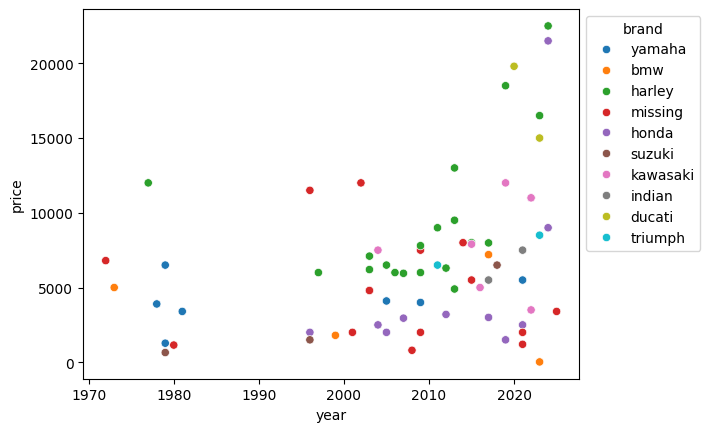

In [85]:
ax = sns.scatterplot(data=df, x='year', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price  log_year
log_price   1.174390  0.001387
log_year    0.001387  0.000050
           log_price  log_year
log_price   1.000000  0.192819
log_year    0.192819  1.000000


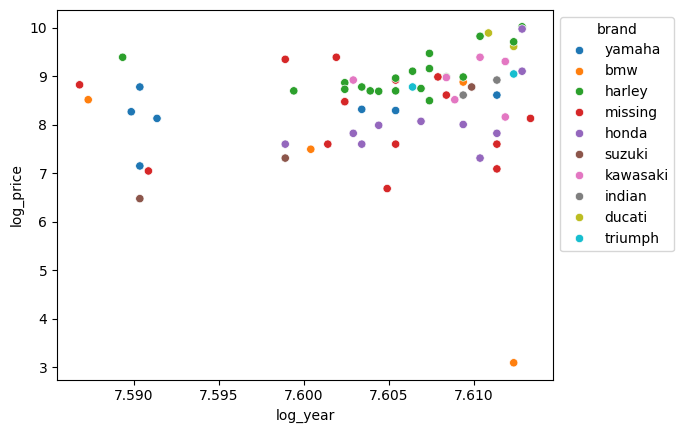

In [86]:
df['log_price'] = np.log(df['price'])
df['log_year'] = np.log(df['year'])

ax = sns.scatterplot(data=df, x='log_year', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_year']].cov())
print(df.loc[:,['log_price','log_year']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.